In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
import scipy.stats as stats
import time, datetime, warnings, os, random, gc, pickle

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from lightgbm import LGBMRegressor
from sklearn.base import clone
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p
from sklearn.linear_model import BayesianRidge

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

warnings.filterwarnings("ignore")
random.seed(0)

2.0.0


In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
print(train_df.shape)
print(test_df.shape)

(1460, 81)
(1459, 80)


***Identifying variables with missing values***

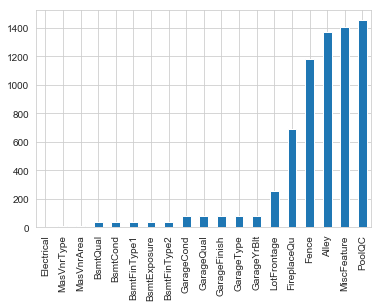

In [3]:
sns.set_style('whitegrid')
nullval = train_df.isnull().sum()
nullval = nullval[nullval > 0]
nullval.sort_values(inplace=True)
nullval.plot.bar()

***Effect of applying log transformation to dependent variable***

50th percentile score: 163000
Mean score: 180921


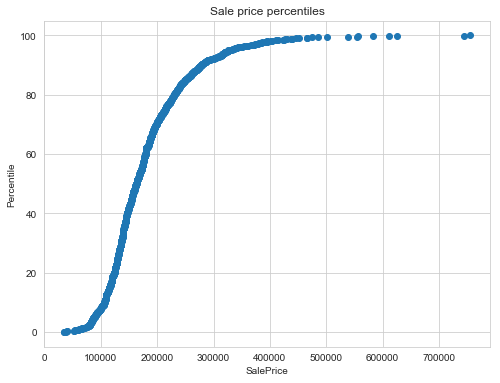

In [4]:
temp_df = pd.get_dummies(train_df)
temp_df['percentile'] = temp_df['SalePrice'].apply(lambda x: stats.percentileofscore(temp_df['SalePrice'], x))
plt.figure(figsize = (8,6))
plt.plot(temp_df['SalePrice'], temp_df['percentile'], 'o')
plt.xlabel('SalePrice'); plt.ylabel('Percentile'); plt.title('Sale price percentiles')
print('50th percentile score: {}'.format(np.min(temp_df.loc[temp_df['percentile']>50, 'SalePrice'])))
print('Mean score: {}'.format(int(np.mean(temp_df['SalePrice']))))

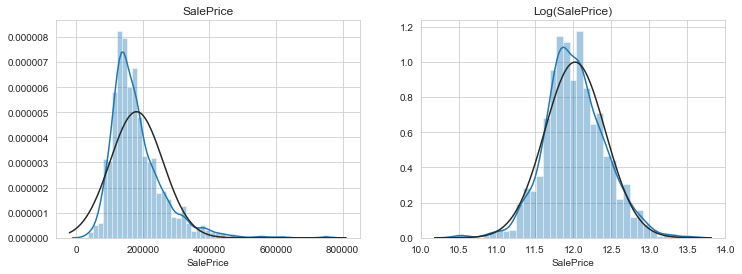

In [5]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.title('SalePrice')
sns.distplot(train_df['SalePrice'], fit=stats.norm)
plt.subplot(1,2,2); plt.title('Log(SalePrice)')
sns.distplot(np.log(train_df['SalePrice']), fit=stats.norm)

***Highly correlated variables***

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64


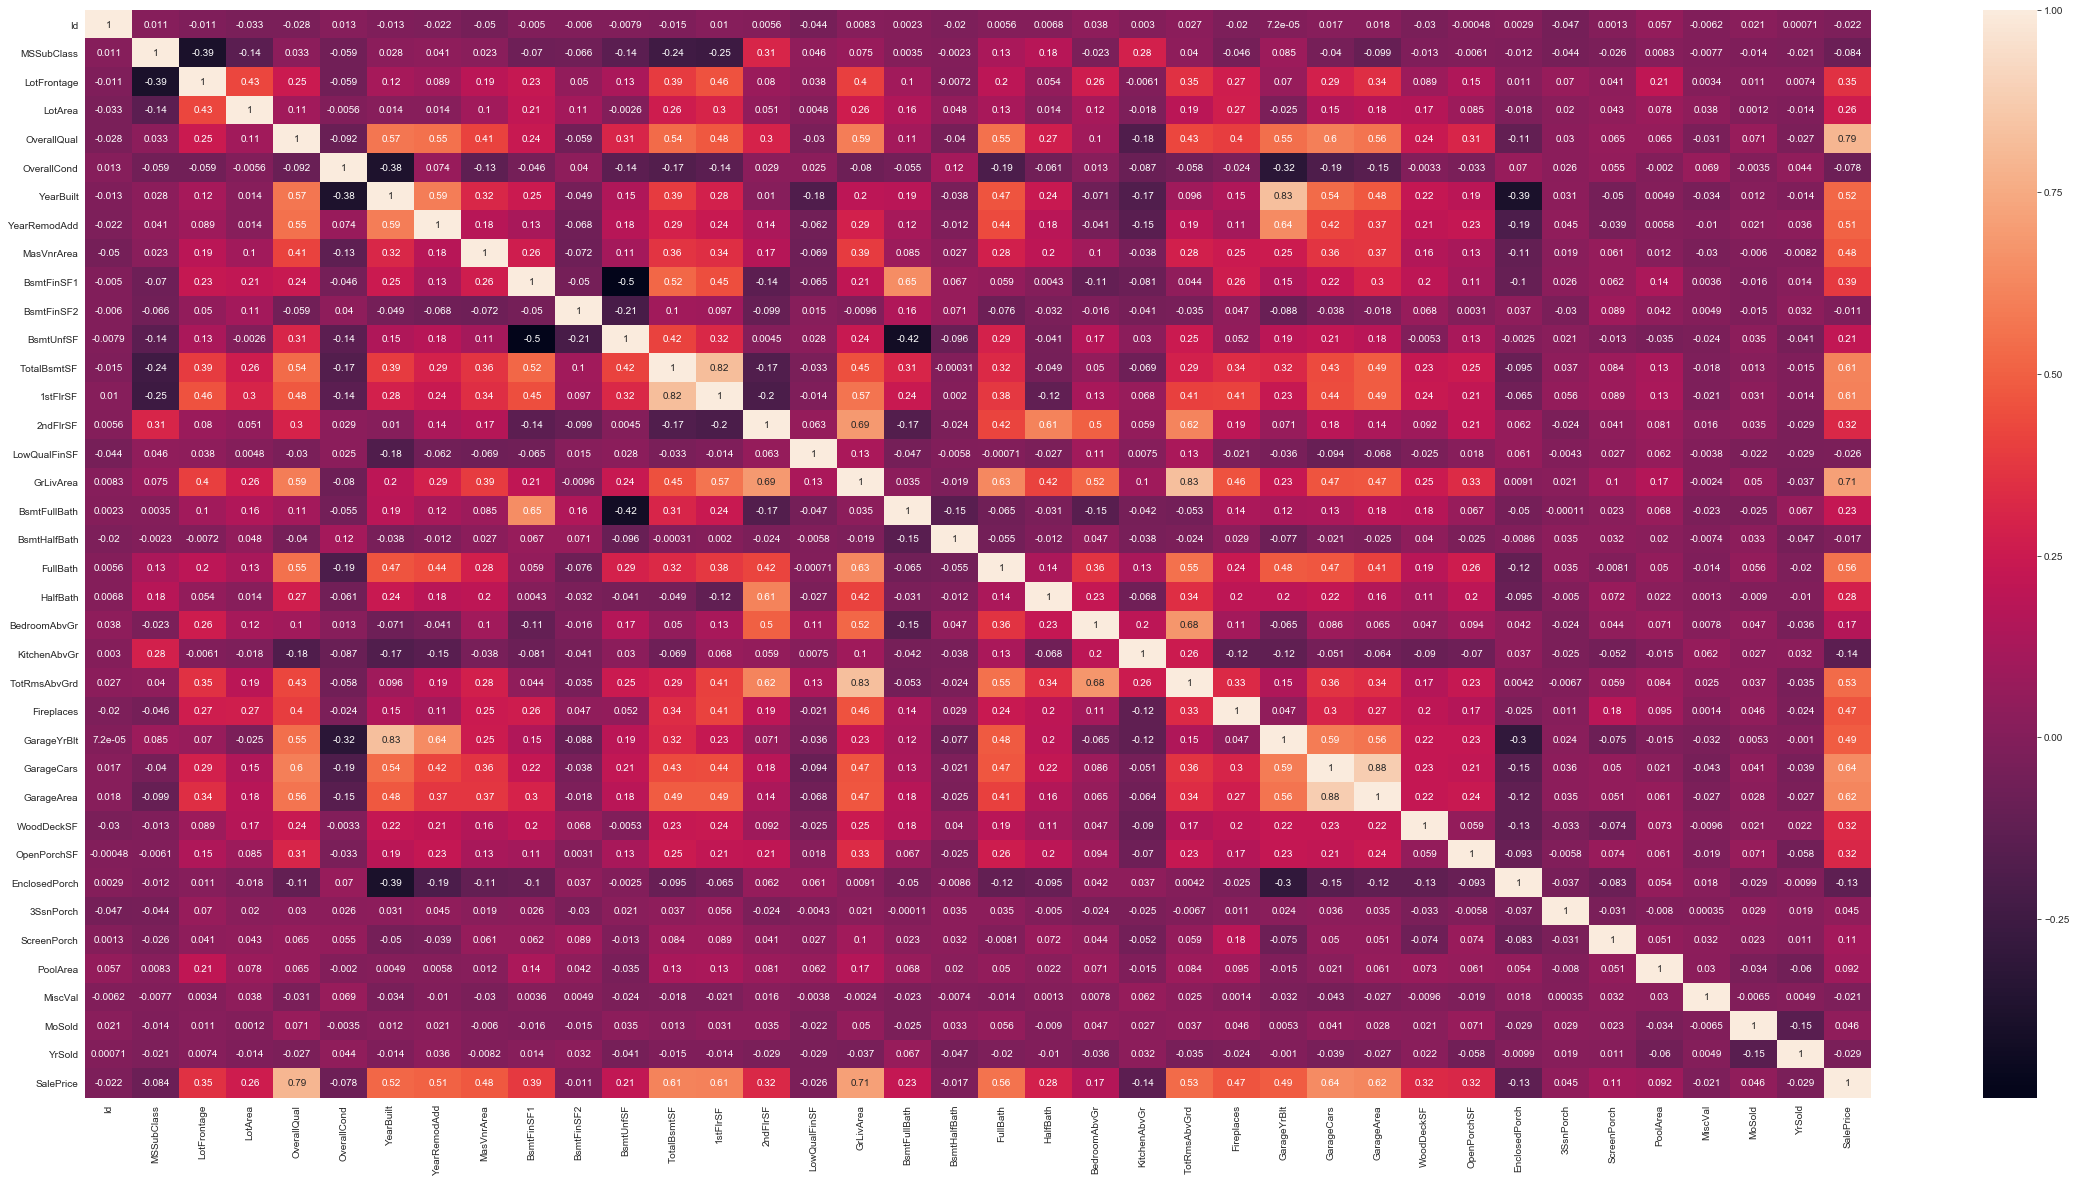

In [6]:
featurecorr = train_df.corr()
#featurecorr.to_csv('housecorr.csv')
plt.figure(figsize=[40,20])
sns.heatmap(featurecorr, annot=True)
#Correlated pairs (correlation to response in bracket):
#Threshold: > 0.85 and < -0.85
#GarageArea(0.62) GarageCars(0.64)
most_correlated = train_df.corr().abs()['SalePrice'].sort_values(ascending=False)
print(most_correlated[:10])

***Visualizing effect of correlated variables*** <br>

Text(0,0.5,'Density')

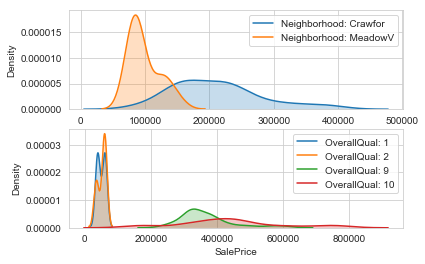

In [7]:
plt.subplot(2, 1, 1)
sns.kdeplot(train_df.loc[train_df['Neighborhood']=='Crawfor', 'SalePrice'], label='Neighborhood: Crawfor', shade=True)
sns.kdeplot(train_df.loc[train_df['Neighborhood']=='MeadowV', 'SalePrice'], label='Neighborhood: MeadowV', shade=True)
plt.xlabel('SalePrice')
plt.ylabel('Density')

plt.subplot(2, 1, 2)
sns.kdeplot(train_df.loc[train_df['OverallQual']==1, 'SalePrice'], label='OverallQual: 1', shade=True)
sns.kdeplot(train_df.loc[train_df['OverallQual']==2, 'SalePrice'], label='OverallQual: 2', shade=True)
sns.kdeplot(train_df.loc[train_df['OverallQual']==9, 'SalePrice'], label='OverallQual: 9', shade=True)
sns.kdeplot(train_df.loc[train_df['OverallQual']==10, 'SalePrice'], label='OverallQual: 10', shade=True)
plt.xlabel('SalePrice')
plt.ylabel('Density')

In [8]:
train_df.groupby('OverallQual')['SalePrice'].agg({'mean', 'min', 'max'})

,mean,min,max
OverallQual,,,
1,50150.000000,39300,61000
2,51770.333333,35311,60000
3,87473.750000,37900,139600
4,108420.655172,34900,256000
5,133523.347607,55993,228950
6,161603.034759,76000,277000
7,207716.423197,82500,383970
8,274735.535714,122000,538000
9,367513.023256,239000,611657


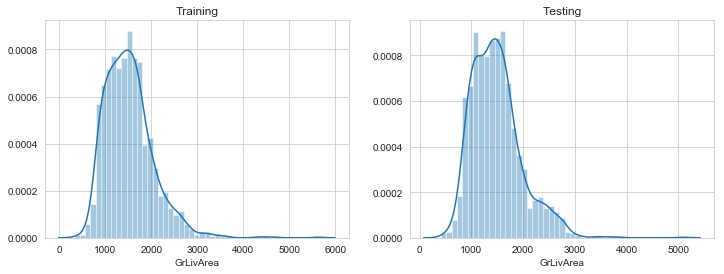

In [9]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.title('Training')
sns.distplot(train_df['GrLivArea'])
plt.subplot(1,2,2); plt.title('Testing')
sns.distplot(test_df['GrLivArea'])

Text(0,0.5,'SalePrice')

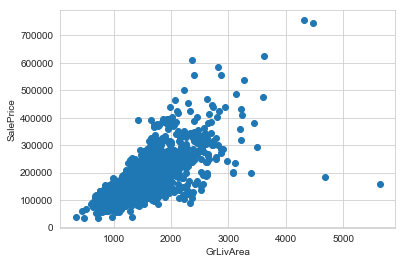

In [10]:
plt.plot(train_df['GrLivArea'], train_df['SalePrice'], 'o')
plt.xlabel('GrLivArea'); plt.ylabel('SalePrice')

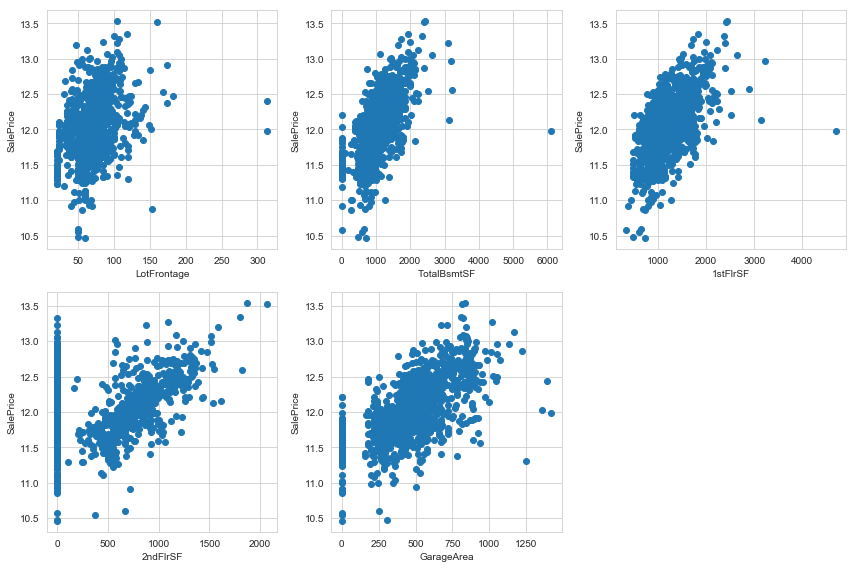

In [11]:
plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
plt.plot(train_df['LotFrontage'], np.log(train_df['SalePrice']), 'o')
plt.xlabel('LotFrontage'); plt.ylabel('SalePrice')
plt.subplot(2,3,2)
plt.plot(train_df['TotalBsmtSF'], np.log(train_df['SalePrice']), 'o')
plt.xlabel('TotalBsmtSF'); plt.ylabel('SalePrice')
plt.subplot(2,3,3)
plt.plot(train_df['1stFlrSF'], np.log(train_df['SalePrice']), 'o')
plt.xlabel('1stFlrSF'); plt.ylabel('SalePrice')
plt.subplot(2,3,4)
plt.plot(train_df['2ndFlrSF'], np.log(train_df['SalePrice']), 'o')
plt.xlabel('2ndFlrSF'); plt.ylabel('SalePrice')
plt.subplot(2,3,5)
plt.plot(train_df['GarageArea'], np.log(train_df['SalePrice']), 'o')
plt.xlabel('GarageArea'); plt.ylabel('SalePrice')
plt.tight_layout()

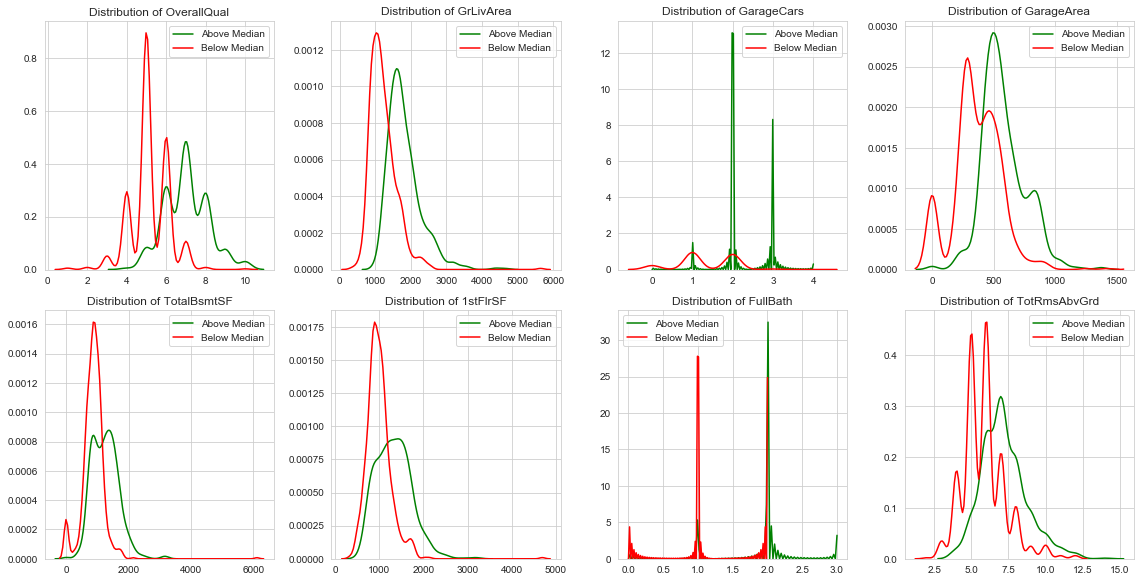

In [12]:
selected_var = most_correlated[:9]
X_df = temp_df[list(selected_var.index)]
X_df['to_median'] = (X_df['SalePrice'] >= 163000)
X_df['to_median'] = X_df['to_median'].replace({True: 'above', False: 'below'})
X_df.drop('SalePrice', axis=1, inplace=True)

plt.figure(figsize=(16,16))
for i, col in enumerate(X_df.columns[:-1]):
    plt.subplot(4, 4, i+1)
    subset_above = X_df[X_df['to_median'] == 'above']
    subset_below = X_df[X_df['to_median'] == 'below']
    sns.kdeplot(subset_above[col], label = 'Above Median', color = 'g')
    sns.kdeplot(subset_below[col], label = 'Below Median', color = 'r')
    plt.legend()
    plt.title('Distribution of {}'.format(col))

plt.tight_layout()

In [13]:
#train_df['FireplaceQu'].value_counts(dropna=False)
#nan in FireplaceQu (quality of fireplace) means no fireplace
#nan in following features: ['LotFrontage', 'FireplaceQu', 'Fence', 'Alley', 'MiscFeature', 'PoolQC'] are legit

In [14]:
num = [col for col in train_df.columns if train_df.dtypes[col] != 'object']
cat = [col for col in train_df.columns if train_df.dtypes[col] == 'object']
num.remove('Id')
num.remove('SalePrice')

***Encoding categorical variables***

In [15]:
def encode(df, feature, ref):
    order = pd.DataFrame()
    order['val'] = df[feature].unique()
    order.set_index('val', drop=True, inplace=True)
    order['spmean'] = df[[feature, ref]].groupby(feature).mean()[ref]
    order.sort_values('spmean', inplace=True)
    order['order'] = range(1, order.shape[0]+1)
    order = order['order'].to_dict()
    for cat, o in order.items():
        df.loc[df[feature]==cat, feature+'_E'] = o

cat_enc = []
for f in cat:
    encode(train_df, f, 'SalePrice')
    cat_enc.append(f + '_E')
print(cat_enc)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


***Visualizing separation: t-SNE components and application of k-means on pca components***

PCA explained variance: 0.7548467146596778


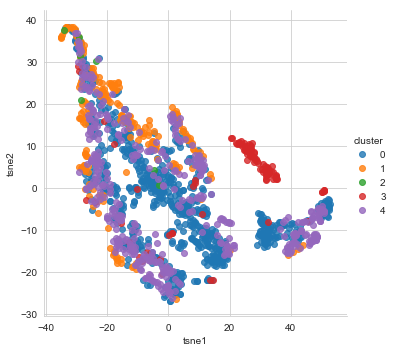

In [16]:
drf = num + cat_enc
X = train_df[drf].fillna(0).values

tsne = TSNE(n_components=2, random_state=0, perplexity=50)
X_tsne = tsne.fit_transform(X)

scaler = StandardScaler()
sX = scaler.fit_transform(X)

pca = PCA(n_components=30)
X_pca = pca.fit_transform(sX)
print('PCA explained variance: {}'.format(np.sum(pca.explained_variance_ratio_)))

kmeans = KMeans(n_clusters=5)
kmeans.fit(X_pca)

vdf = pd.DataFrame({'tsne1': X_tsne[:,0], 'tsne2': X_tsne[:,1], 'cluster': kmeans.labels_})
sns.lmplot(x='tsne1', y='tsne2', data=vdf, hue='cluster', fit_reg=False)

In [17]:
x_train = train_df[num + cat + ['SalePrice']]
test_df.set_index('Id', drop=True, inplace=True)
x_test = test_df
x_test.loc[x_test['MSSubClass'] == 150, 'MSSubClass'] = 120

In [18]:
def prep_data(X):
    X['MSSubClass'] = X['MSSubClass'].astype(str)
    X['TotalSF'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']
    X['LotFrontage'] = X.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    
    #Imputation of numerics with 0
    X.update(X.select_dtypes(include=['int', 'float']).fillna(0))
    
    X['GarageYrBlt'] = X['GarageYrBlt'].astype('int')
    
    X['YearRemodAdd'] = X['YearRemodAdd'] - X['YearRemodAdd'].min()
    X['YearBuilt'] = X['YearBuilt'] - X['YearBuilt'].min()
    X['GarageYrBlt'] = X['GarageYrBlt'] - X['GarageYrBlt'].min()
    X['YrSold'] = X['YrSold'] - X['YrSold'].min()
    
    return X

def add_cols(X):
    
    droplist = []
    for i in X.columns:
        counts = X[i].value_counts()
        z = counts.iloc[0]
        if z/len(X) > 0.995:
            droplist.append(i)
    print(droplist)
    X = X.drop(droplist, axis=1)
    
    #X['BsmtFinType1_Unf_Ind'] = (X['BsmtFinType1'] == 'Unf') * 1
    X['HasWoodDeck'] = (X['WoodDeckSF'] > 0) * 1
    X['HasOpenPorch'] = (X['OpenPorchSF'] > 0) * 1
    X['HasEnclosedPorch'] = (X['EnclosedPorch'] > 0) * 1
    X['Has3SsnPorch'] = (X['3SsnPorch'] > 0) * 1
    X['HasScreenPorch'] = (X['ScreenPorch'] > 0) * 1
    X['HasGarage'] = (X['GarageArea'] > 0) * 1
    X['HasBsmt'] = (X['TotalBsmtSF'] > 0) * 1
    X['HasFireplace'] = (X['Fireplaces'] > 0) * 1
    X['Has2ndfloor'] = (X['2ndFlrSF'] > 0) * 1
    X['HasPool'] = (~X['PoolQC'].isnull()) * 1
    X['TotalQuality'] = X['OverallQual'] + X['OverallCond']
    
    X = X.drop('GarageArea', axis=1) #multicollinearity
    
    loglist = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
               '1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath',
               'HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars',#'GarageArea',
               'WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','MiscVal',#'PoolArea',
               'TotalSF']
    
    for l in loglist:
        X[l+'_log'] = np.log1p(X[l])
        X = X.drop(l, axis=1)
    
    sqlist = ['LotFrontage_log', 'TotalBsmtSF_log', '1stFlrSF_log', '2ndFlrSF_log', 'GrLivArea_log',
              'GarageCars_log'] #'GarageArea_log'
    
    for l in sqlist:
        X[l+'_sq'] = X[l]*X[l]
    
    catlist = ['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 
               'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 
               'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 
               'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 
               'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 
               'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
    X = pd.get_dummies(X, columns = catlist)
    
    return X

#manual remove of outliers
x_train = x_train[~((x_train['SalePrice']>200000) & (x_train['OverallQual']<5))]
x_train = x_train[~((x_train['SalePrice']<300000) & (x_train['GrLivArea']>4000))]
#x_train.drop(1298, axis=0, inplace=True)

y_train = np.log(x_train['SalePrice'])
x_train.drop('SalePrice', axis=1, inplace=True)

#x_train = prep_data(x_train)
#x_test = prep_data(x_test)
#x_test = pd.DataFrame({col: x_test.get(col, 0) for col in x_train.columns})

x_c = pd.concat([x_train, x_test], axis=0)
x_c = prep_data(x_c)
num.remove('MSSubClass')
skewvals = x_c[num].apply(lambda x: skew(x)).sort_values(ascending=False)
skew_ind = list(skewvals[skewvals>0.5].index)
for i in skew_ind:
    x_c[i] = boxcox1p(x_c[i], boxcox_normmax(x_c[i]+0.01))

x_c = add_cols(x_c)
trainlen = x_train.shape[0]
x_train = x_c.iloc[:trainlen,:]
x_test = x_c.iloc[trainlen:,:]

['PoolArea', 'Street', 'Utilities']


In [19]:
#import statsmodels.api as sm
#ols = sm.OLS(endog = y_train, exog = x_train)
#fit = ols.fit()
#t = fit.outlier_test()['bonf(p)']
#outliers = list(t[t<1e-3].index)

***Automatic removal of outliers through model of interest (Bayesian Ridge)***

In [20]:
#removal of outliers
outliers = [30, 462, 632, 1324]
x_train.drop(outliers, axis=0, inplace=True)
y_train.drop(outliers, axis=0, inplace=True)

cv_errors = np.abs(cross_val_predict(BayesianRidge(), x_train, y_train, n_jobs=-1, cv=10) - y_train)
outliers = list(cv_errors[cv_errors > (np.mean(cv_errors) + 2 * np.std(cv_errors))].index)
x_train.drop(outliers, inplace=True)
y_train.drop(outliers, inplace=True)

In [21]:
#scaling
rscaler = RobustScaler()
x_train = pd.DataFrame(rscaler.fit_transform(x_train), index=x_train.index, columns=list(x_train.columns))
x_test = pd.DataFrame(rscaler.transform(x_test), index=x_test.index, columns=list(x_test.columns))

x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

***Experimentation of neural network (layers, activation, units) resulted in the following 5-layer sequential model*** <br>
Results are inferior to the subsequent Bayesian Ridge Regression model

In [22]:
def build_model():
  model = keras.Sequential([
    layers.Dense(300, activation='relu', input_shape=[len(x_train.keys())]),
    layers.Dense(300, activation = 'tanh'),
    layers.Dense(150, activation='relu'),
    layers.Dense(30, activation='tanh'),
    layers.Dense(1, activation='linear')
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [23]:
print('Finding optimal layers and parameters')
nn = build_model()
nn.summary()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
history = nn.fit(x_train, y_train, epochs=1000, verbose=0, 
                 callbacks=[early_stop], validation_split=0.2)

Finding optimal layers and parameters
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               94200     
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 150)               45150     
_________________________________________________________________
dense_3 (Dense)              (None, 30)                4530      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 31        
Total params: 234,211
Trainable params: 234,211
Non-trainable params: 0
_________________________________________________________________


In [25]:
#from sklearn.metrics import mean_squared_error

#kf = KFold(n_splits=10, random_state=0, shuffle=True)

#for i, (train_ind, val_ind) in enumerate(kf.split(x_train, y_train)):
#    xtrain, xval = x_train.iloc[train_ind], x_train.iloc[val_ind]
#    ytrain, yval = y_train[train_ind], y_train[val_ind]
#    
#    nn = build_model()
    #nn.summary()
#    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
#    history = nn.fit(xtrain, ytrain, epochs=1000, verbose=0, callbacks=[early_stop], validation_data = (xval, yval))
#    print('Fold {}'.format(i))
#    print('     Keras Sequential: {}'.format(mean_squared_error(nn.predict(xval), yval)))

***Applying PCA to account for correlation among variables***

In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=313)
x_train = pca.fit_transform(x_train)
xtestindex = x_test.index
x_test = pca.transform(x_test)

In [27]:
bayridgereg = BayesianRidge().fit(X=x_train, y=y_train)
bayridgepred = np.exp(bayridgereg.predict(x_test))

***While other models are inferior to BayesianRidge, the stacking of such models provide a good altnerative.*** <br>
***Combining BayesianRidge and the stacked model resulted in reduced errors. An optimal weights of 70/30 is obtained through testing.***

In [39]:
from mlxtend.regressor import StackingCVRegressor
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

kfolds = KFold(n_splits=10, random_state=0, shuffle=True)

ridge = RidgeCV(cv=kfolds)

lasso = LassoCV(random_state = 42, cv=kfolds)

elasticnet = ElasticNetCV(max_iter=1e7, cv=kfolds)

lightgbm = LGBMRegressor(objective='regression',num_leaves=5,
                         learning_rate=0.01, n_estimators=800)

xgboost = XGBRegressor(learning_rate =0.01, n_estimators=1000, 
                       max_depth=3,min_child_weight=0 ,
                       gamma=0, subsample=0.7,
                       colsample_bytree=0.7,
                       objective= 'reg:squarederror')

#stack
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, 
                                            xgboost, lightgbm), 
                               meta_regressor=xgboost,
                               use_features_in_secondary=True)

#prepare dataframes
x_train_stack = np.array(x_train)
y_train_stack = np.array(y_train)
stack_gen_model = stack_gen.fit(x_train_stack, y_train_stack)
stack_gen_preds = np.exp(stack_gen_model.predict(np.array(x_test)))

In [40]:
pred = 0.7 * bayridgepred + 0.3 * stack_gen_preds

In [ ]:
submission = pd.DataFrame({'Id': xtestindex, 'SalePrice': pred})
submission.to_csv('submission.csv', index=False)

In [ ]:
coef = np.abs(bayridgereg.coef_)
#print(coef.argmax())
#print(coef[15])
np.argsort(coef)[::-1]
#print(x_train[[15, 69, 3, 73, 5, 85, 36, 234]])